### Libraries

In [10]:
from urllib.parse import urlparse
from urllib.parse import urldefrag

from urllib.request import urlopen
from file_storage import FileStorage

from bs4 import BeautifulSoup
from urllib.parse import urljoin

from queue import Queue

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

---
###### Some functions

In [2]:
def extract_links_from_html(url, html):
    parser = BeautifulSoup(html, "lxml")
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]

---
###### Solution

In [3]:
fs = FileStorage('storage')

---
###### Пронумеруем все урлы и выкинем лишние

In [4]:
url_idx = {}

not_articles = ['/wiki/Help:', '/wiki/Help_talk', '/wiki/File:', '/wiki/Media:', '/wiki/MediaWiki:', 
                '/wiki/MediaWiki_talk:', '/wiki/Module:', '/wiki/Talk:', '/wiki/Category:', 
                '/wiki/Category_talk:', '/wiki/User:', '/wiki/User_talk:', '/wiki/Special:', '/wiki/Template:', 
                '/wiki/Template_talk:', '/wiki/Wikipedia:', '/wiki/Wikipedia_talk:']

url_counter = 0

for url in tqdm_notebook(fs.dict.keys()):
    if all(map(lambda x: x not in url, not_articles)):
        url_idx[url] = url_counter
        url_counter += 1

---
###### Для каждого урла посчитаем количество входящих ссылок

In [5]:
L = {}

for url in tqdm_notebook(url_idx.keys()):
    links = extract_links_from_html(url, fs.read(url))
    L[url] = np.sum([1 if all(map(lambda x: x not in link, not_articles)) else 0 for link in links])

---
###### Итеративным алгоритмом посчитаем PageRank

In [6]:
def calcPageRank(start_url='https://simple.wikipedia.org/wiki/Main_Page', delta=0.85, tol=0.1, verbose=True):

    pr = np.zeros(len(url_idx)) + 1

    iter_counter = 0
    
    residuals = []
    
    while True:
        next_pr = np.zeros(len(url_idx)) + (1 - delta)
        
        for url in tqdm_notebook(url_idx.keys()) if verbose else url_idx.keys():
            
            idx_from = url_idx[url]
            
            links = extract_links_from_html(url, fs.read(url))
            for link in links:
                link = urldefrag(link).url
                if link in url_idx:
                    idx_to = url_idx[link]
                    next_pr[idx_to] += delta / L[url] * pr[idx_from]
        
        iter_counter += 1
        
        if verbose:
            print('iteration %d' % iter_counter)
            print('residual is %.2f' % np.max(np.absolute(pr - next_pr)))
            residuals.append(np.max(np.absolute(pr - next_pr)))
        
        if np.max(np.absolute(pr - next_pr)) < tol:
            break
                             
        pr = next_pr
        
    if verbose:
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(len(residuals)), residuals, label='residuals')
        plt.xlabel('number of iteration', fontsize=16)
        plt.ylabel('$\\max_{i} ~|PageRank(i) - PageRank_{next}(i)|$', fontsize=16)
        plt.show()
        
    return pr


iteration 1
residual is 3757.53



iteration 2
residual is 2386.57



iteration 3
residual is 466.30



iteration 4
residual is 114.08



iteration 5
residual is 34.48



iteration 6
residual is 11.83



iteration 7
residual is 4.46



iteration 8
residual is 1.84



iteration 9
residual is 0.83



iteration 10
residual is 0.41



iteration 11
residual is 0.22



iteration 12
residual is 0.12



iteration 13
residual is 0.07


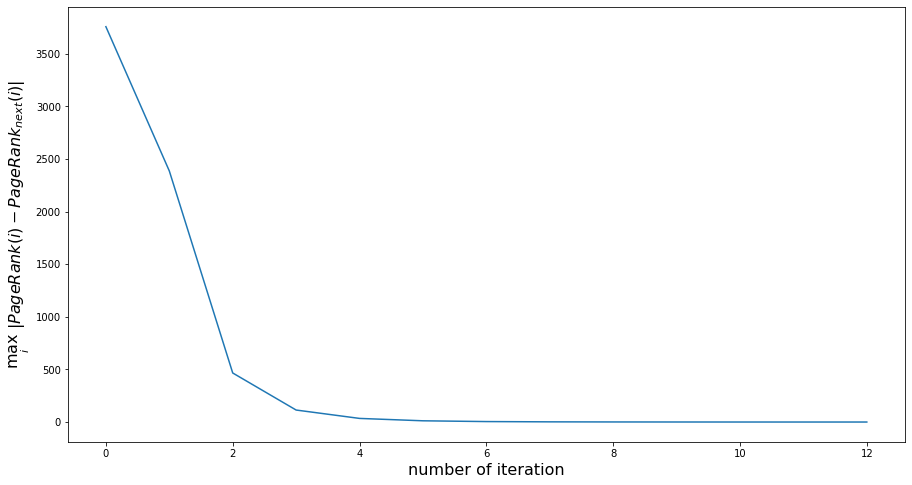

In [7]:
pr = calcPageRank()

---
###### Сохраним результат

In [30]:
page_rank = pd.DataFrame(np.vstack((np.array(list(url_idx.keys())), (pr / pr.max()))).T, columns=['url', 'pageRank'])

page_rank = page_rank.sort_values(by='pageRank', ascending=False)

In [32]:
page_rank.head()

,url,pageRank
0,https://simple.wikipedia.org/wiki/Main_Page,1.0
610,https://simple.wikipedia.org/wiki/United_States,0.08853799126365515
140,https://simple.wikipedia.org/wiki/Internationa...,0.07367078407624889
475,https://simple.wikipedia.org/wiki/France,0.05173466525240726
1436,https://simple.wikipedia.org/wiki/Americans,0.034994558039275876


In [34]:
page_rank.to_csv('page_rank_simple_wiki.csv', index=False)